# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.391155,False,-0.519657
1,1.471143,True,9.621192
2,-0.882611,True,4.356757
3,-0.834870,False,-3.443394
4,0.171305,False,1.428308
...,...,...,...
995,-0.345854,False,-0.943828
996,-1.822211,True,1.224008
997,-1.418376,False,-4.615610
998,-0.715219,True,3.554194


<Axes: xlabel='v0'>

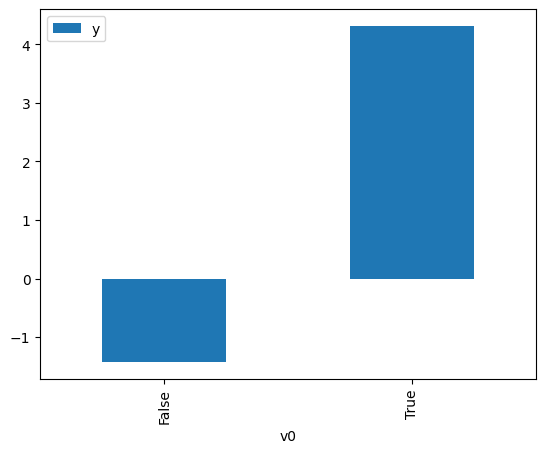

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

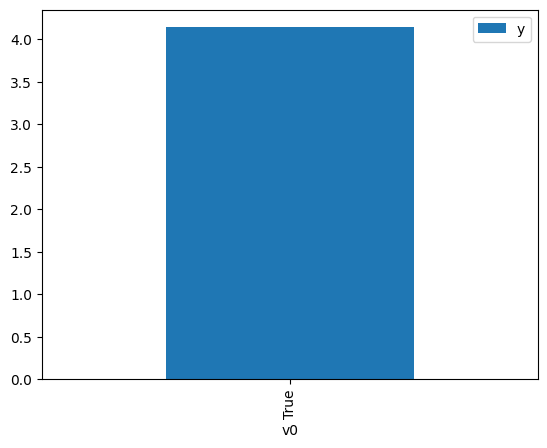

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.215693,False,4.222454,0.065018,15.380332
1,-0.549455,False,-0.757690,0.750900,1.331736
2,0.118036,False,1.872855,0.420204,2.379798
3,-1.243431,False,-3.002130,0.929911,1.075372
4,-0.154662,False,-0.859458,0.564729,1.770760
...,...,...,...,...,...
995,0.967997,False,2.350017,0.105558,9.473433
996,-0.154914,False,-0.123670,0.564862,1.770344
997,-0.024645,False,1.665969,0.495686,2.017407
998,0.832697,False,2.574928,0.136106,7.347218


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.753356,True,4.222045,0.176706,5.659106
1,1.017486,True,7.299945,0.904012,1.106181
2,0.622581,True,6.327894,0.802079,1.246760
3,0.286390,True,5.606851,0.664060,1.505888
4,1.378038,True,9.099322,0.953137,1.049167
...,...,...,...,...,...
995,0.386150,True,4.663700,0.709811,1.408826
996,-1.822201,True,-0.933880,0.021432,46.660056
997,-1.822211,True,1.224008,0.021431,46.661037
998,-0.045259,True,4.028427,0.493310,2.027121


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.177e+04
Date:                Sun, 30 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:07:16   Log-Likelihood:                         -1424.1
No. Observations:                1000   AIC:                                      2852.
Df Residuals:                     998   BIC:                                      2862.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8509      0.029     97.034      0.000       2.793       2.909
x2             5.0268      0.053     95.096      0.000       4.923       5.131
==============================================================================
Omnibus:                        3.889   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.072
Skew:                           0.085   Prob(JB):                        0.131
Kurtosis:                       3.262   Cond. No.                         1.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""